New frequency datasets

In [179]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime

Check if CUDA is available

In [180]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [181]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Base dataset class

In [182]:
class BaseFourierDataset(Dataset):
    def __init__(self, num_samples, num_points, max_freq):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_freq = max_freq
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.first_derivatives = self.generate_data()

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + n_terms] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.FloatTensor(self.functions[idx][1:]), torch.FloatTensor(self.first_derivatives[idx][1:])

    def generate_data(self):
        raise NotImplementedError("Subclasses must implement generate_data method")

In [183]:
class LowFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, max_freq=5):
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients only for low frequencies (1 to max_freq)
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            c[self.max_freq-self.max_freq:self.max_freq+self.max_freq+1] = torch.complex(torch.randn(2*self.max_freq+1), torch.randn(2*self.max_freq+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            y = y - y[0]  # Ensure f(0) = 0
            functions.append(y.detach().numpy())

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)

class LowFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, max_freq=5):
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients only for low frequencies (1 to max_freq)
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            c[self.max_freq-self.max_freq:self.max_freq+self.max_freq+1] = torch.complex(torch.randn(2*self.max_freq+1), torch.randn(2*self.max_freq+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            y = y - y[0]  # Ensure f(0) = 0
            functions.append(y.detach().numpy())

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)

class HighFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, min_freq=20, max_freq=30):
        self.min_freq = min_freq
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            high_freq_coeffs = torch.complex(torch.randn(self.max_freq-self.min_freq+1), 
                                            torch.randn(self.max_freq-self.min_freq+1))
            c[self.max_freq+self.min_freq:] = high_freq_coeffs
            c[:self.max_freq-self.min_freq+1] = torch.conj(high_freq_coeffs.flip(0))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            y = y - y[0]  # Ensure f(0) = 0

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

            functions.append(y.detach().numpy())
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)


In [184]:
num_samples = 100
num_points = 1000

low_freq_dataset = LowFrequencyFourierDataset(num_samples, num_points, max_freq=5)
high_freq_dataset = HighFrequencyFourierDataset(num_samples, num_points, min_freq=20, max_freq=30)

# Create DataLoaders
batch_size = 32
low_freq_dataloader = DataLoader(low_freq_dataset, batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(high_freq_dataset, batch_size=batch_size, shuffle=True)

# Save datasets
torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

Low frequency dataset

In [185]:
dataset_l = torch.load('datasets/low_freq_dataset.pt')
total_size = len(dataset_l)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_l, test_dataset_l = random_split(dataset_l, [train_size, test_size], generator=generator)

High frequency dataset

In [186]:
dataset_h = torch.load('datasets/high_freq_dataset.pt')
total_size = len(dataset_h)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_h, test_dataset_h = random_split(dataset_h, [train_size, test_size], generator=generator)

In [187]:
len(train_dataset_l[1])

2

## Plot a function

Low freq function

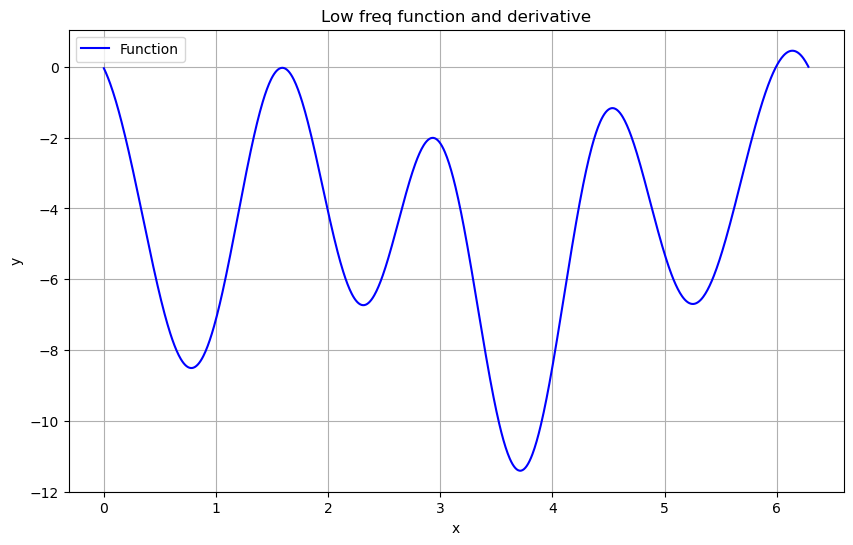

In [188]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    # plt.plot(x[10:-10], derivative[10:-10], label='First Derivative', linestyle='--')
    # plt.plot(x, derivative, label='First Derivative', linestyle='--')
    
    plt.title('Low freq function and derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(dataset=train_dataset_l, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

High freq function

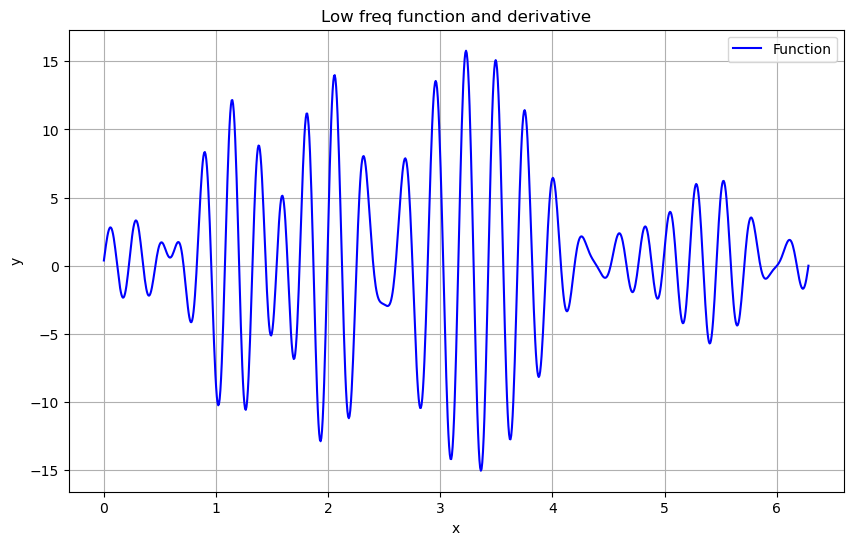

In [189]:
train_dataloader_viz = get_random_function(dataset=train_dataset_h, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)